2. iv. Can one use regression to associate CREs with gene expression?

    - a. How much of the variance of gene expression can be explained for each gene with this approach?

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
#REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# --- 1. Load Data ---
# 1.1 CRE annotations (must include 'peak_id' and 'nearest_gene')
peaks = pd.read_csv(PROC_PEAKS_PATH)
#peaks["peak_id"] = peaks.index  # ensure a unique integer ID

# 1.2 ATAC accessibility (peaks × cellTypes)
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])#.drop(["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"])
atac = atac.select_dtypes(include=[np.number])
#atac = atac.mean(axis=1, numeric_only=True)
#atac.index.names = ["chrom","start","end"]

# 1.3 RNA expression (genes × cellTypes)
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)
#rna = rna.mean(axis=1, numeric_only=True)

In [66]:
# --- 2. Build gene → CRE mapping ---
# We'll use the 'TSS_GeneName' field to link peaks to their gene.
#gene_to_peaks = peaks.groupby("TSS_GeneName")["id"].apply(list).to_dict()

# 2.1 Explode the gene lists
peaks["gene_list"] = peaks["genes.within.100Kb"].str.split(",")
peaks_exploded = peaks.explode("gene_list").rename(columns={"gene_list":"gene"})
# Drop any empty gene entries
peaks_exploded = peaks_exploded[peaks_exploded["gene"].notna() & (peaks_exploded["gene"]!="")]

# 2.2 Group to get mapping: gene → list of peak_ids
gene_to_peaks = peaks_exploded.groupby("gene")["id"].apply(list).to_dict()

# --- 3. Perform regression ---
def perform_regression(atac_data, rna_data):
    """
    Perform linear regression for each gene based on ATAC data.
    
    Parameters:
    - atac_data: DataFrame with ATAC accessibility data (peaks × cellTypes).
    - rna_data: DataFrame with RNA expression data (genes × cellTypes).
    
    Returns:
    - results: DataFrame with regression results for each gene.
      Contains columns: 'gene', 'R2', 'n_CRes'.
    - peak_means: DataFrame with mean values for RNA and ATAC peaks.
    """
    results = []
    peak_means = []
    model = LinearRegression()

    for gene, peak_ids in gene_to_peaks.items():
        # skip if gene not in RNA or too few CREs
        if gene not in rna_data.index or len(peak_ids) < 2:
            continue

        # Build X: shape (n_cellTypes, n_peaks)
        sub = atac_data.loc[peak_ids]  # DataFrame: rows=CREs, cols=cell types

        # DROP any CRE row with NA
        sub_clean = sub.dropna(axis=0, how="any")
        if sub_clean.shape[0] < 2:
            continue

        X = sub_clean.values.T  # transpose → samples × features

        # Build y: expression vector for this gene across same cellTypes
        y = rna_data.loc[gene].values

        peak_means.append({"RNA Peak Strength": y.mean(), "ATAC Peak Strength": X.mean(axis=0)})

        # Fit and record R^2
        try:
            model.fit(X, y)
            r2 = model.score(X, y)
            beta = model.coef_
        except Exception as e:
            logging.warning(f"Regression failed for {gene}: {e}")
            continue

        results.append({"gene": gene, "R2": r2, "beta": beta, "n_CRes": len(peak_ids)})
    
    print(f"Computed R² for {len(results)} genes.")
    return pd.DataFrame(results).sort_values("R2", ascending=False), pd.DataFrame(peak_means).explode("ATAC Peak Strength")

In [67]:
# Align to only the intersection of cell types
common_cells = atac.columns.intersection(rna.columns)
if len(common_cells) < len(atac.columns) or len(common_cells) < len(rna.columns):
    print(f"Aligning to {len(common_cells)} common cell types "
          f"(was {len(atac.columns)} ATAC, {len(rna.columns)} RNA)")

results, peak_means = perform_regression(atac[common_cells], rna[common_cells])

Aligning to 85 common cell types (was 93 ATAC, 86 RNA)
Computed R² for 17469 genes.


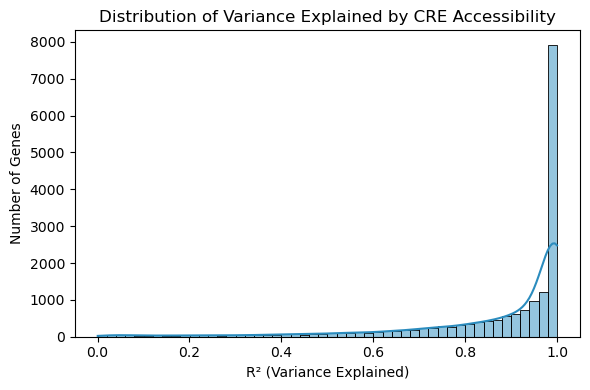

count    17469.000000
mean         0.873958
std          0.198776
min          0.000491
25%          0.830172
50%          0.967230
75%          1.000000
max          1.000000


In [68]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results["R2"], bins=50, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results["R2"].describe().to_string())

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

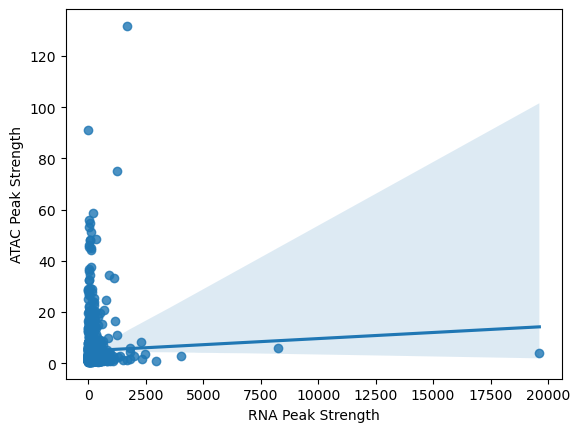

In [69]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means["ATAC Peak Strength"] = peak_means["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(data=peak_means.sample(1000), x="RNA Peak Strength", y="ATAC Peak Strength")

    - b. How do the coefficients differ when it is performed on your cell lineage alone?

In [70]:
ilc_columns = ["NK.27+11b-.BM","NK.27+11b+.BM","NK.27-11b+.BM","NK.27+11b-.Sp","NK.27+11b+.Sp","NK.27-11b+.Sp","ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI"]
results_ilc, peak_means_ilc = perform_regression(atac[ilc_columns], rna[ilc_columns])

Computed R² for 17469 genes.


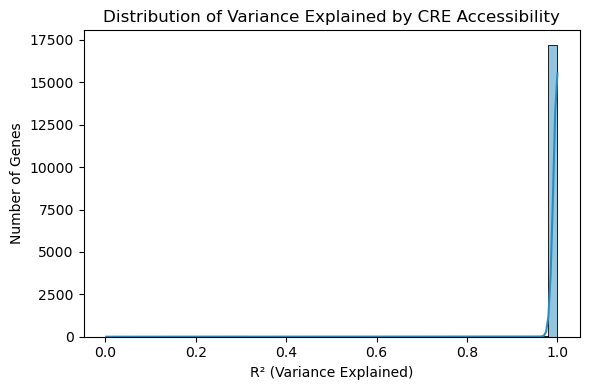

count    17469.000000
mean         0.993551
std          0.062239
min          0.001653
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000


In [71]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results_ilc["R2"], bins=50, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results_ilc["R2"].describe().to_string())

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

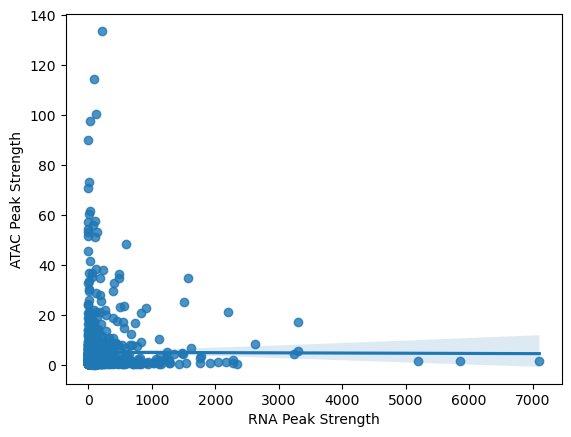

In [72]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means_ilc["ATAC Peak Strength"] = peak_means_ilc["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(
	data=peak_means_ilc.sample(1000),
	x="RNA Peak Strength",
	y="ATAC Peak Strength"
)

In [ ]:
comp = pd.DataFrame({
    "beta_global": results["beta"],
    "beta_ilc": results_ilc["beta"],
    #"beta_diff": results["beta"] - results_ilc["beta"]
})

#sns.histplot(comp["beta_diff"].dropna(), bins=50, kde=True)
#plt.title("Distribution of β(Global) − β(ILC)")
#plt.xlabel("Coefficient Difference")
#plt.savefig("reports/beta_diff_distribution.png")
#plt.show()

# 2) Scatter β_global vs β_ilc
sns.jointplot(x="beta_global", y="beta_ilc", data=comp, kind="hex", marginal_kws=dict(bins=30))
plt.xlabel("β (Global)")
plt.ylabel("β (ILC)")
plt.suptitle("Global vs ILC Coefficients per CRE")
#plt.savefig("reports/beta_global_vs_beta_ilc.png")
plt.show()


ValueError: operands could not be broadcast together with shapes (105,) (96,) 